In [1]:
# Cell 1: Setup
%load_ext autoreload
%autoreload 2

import sys
import gc
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import accuracy_score

# Setup path
sys.path.append(str(Path.cwd().parent))
from src import config, preprocessing, autoencoder, rf_classifier, evaluation, utils

# Tạo folder lưu kết quả riêng cho Cross-Test (Reverse)
exp_paths = utils.setup_experiment_folder()
utils.log_experiment_details(exp_path=exp_paths['root'])
print(f"📂 Saving results to: {exp_paths['root']}")

📂 New Experiment Created: C:\Users\Admin\Documents\ids_ae_rf_hybrid\results\experiments\exp_20251218_224408
       EXPERIMENT SUMMARY - 2025-12-18 22:44:08
🚀 Device: cuda
📂 Exp Path: C:\Users\Admin\Documents\ids_ae_rf_hybrid\results\experiments\exp_20251218_224408

--- DATA CONFIGURATION ---
🔹 Binary Mode: True
🔹 Random Seed: 42
🔹 Selected Features (Total): 65
🔹 mRMR Features (K): 20

--- AUTOENCODER HYPERPARAMETERS ---
🔸 Input Dim: 30
🔸 Latent Dim (N): 5
🔸 Hidden Layers: [22, 12]
🔸 Epochs: 20
🔸 Batch Size: 16384
🔸 Learning Rate: 0.001

--- RANDOM FOREST HYPERPARAMETERS ---
🔸 Estimators: 100
🔸 Max Depth: 12
✅ Experiment details saved to: C:\Users\Admin\Documents\ids_ae_rf_hybrid\results\experiments\exp_20251218_224408\experiment_details.txt
📂 Saving results to: C:\Users\Admin\Documents\ids_ae_rf_hybrid\results\experiments\exp_20251218_224408


In [2]:
# ==============================================================================
# KỊCH BẢN 2: TRAIN TRÊN 2018 -> TEST TRÊN 2017
# ==============================================================================

# Cell 2: Load Data 2018 (TRAIN)
print("\n--- 1. LOADING TRAIN SET (CSE-CIC-IDS2018) ---")
# [THAY ĐỔI]: Load 2018 làm tập Train
df_train, y_train = preprocessing.load_single_dataset_year('2018', binary_mode=True)

# Chuyển sang numpy để đưa vào model
X_train = df_train.values

print(f"Training Data Shape: {X_train.shape}")
print(f"Label Distribution: {pd.Series(y_train).value_counts()}")


--- 1. LOADING TRAIN SET (CSE-CIC-IDS2018) ---
🔄 Loading dataset year 2018 (Binary=True)...
✅ Loaded 2018. Shape: (9625148, 65)
Training Data Shape: (9625148, 65)
Label Distribution: Label
0    6876913
1    2748235
Name: count, dtype: int64


In [3]:
# Cell 3: Scaling (Fit on Train 2018)
print("\n--- 2. SCALING ---")
scaler = preprocessing.get_scaler()
# [THAY ĐỔI]: Fit trên 2018
X_train_scaled = scaler.fit_transform(X_train)
print("✅ Scaler fitted on 2018.")


--- 2. SCALING ---
✅ Scaler fitted on 2018.


In [5]:
# Cell 4: Train Autoencoder on 2018
print("\n--- 3. TRAIN AUTOENCODER ---")

# 1. Xác định chỉ số của 30 đặc trưng đầu tiên
# (Giả sử X_train_scaled của bạn đang có 65 cột theo thứ tự mRMR)
L = 30 
X_train_ae_input = X_train_scaled[:, :L] # Lấy 30 cột đầu tiên

# 2. Khởi tạo model (Đảm bảo input_dim khớp với dữ liệu đã cắt)
ae_model = autoencoder.DeepAutoencoder(
    input_dim=L, # Phải là 30
    latent_dim=config.AE_LATENT_DIM,
    hidden_layers=config.AE_HIDDEN_LAYERS
)

ae_save_path = exp_paths['models'] / "ae_model_2018.pth"

# 3. Truyền dữ liệu ĐÃ CẮT (X_train_ae_input) vào hàm train
ae_model = autoencoder.train_ae(ae_model, X_train_ae_input, save_path=ae_save_path)


--- 3. TRAIN AUTOENCODER ---
[Autoencoder] Training on cuda...
  Epoch 5/20 - Loss: 0.231374
  Epoch 10/20 - Loss: 0.124190
  Epoch 15/20 - Loss: 0.109625
  Epoch 20/20 - Loss: 0.098436
✅ AE Model saved to: C:\Users\Admin\Documents\ids_ae_rf_hybrid\results\experiments\exp_20251218_224408\models\ae_model_2018.pth


In [7]:
# Cell 5: Prepare Fusion Data for Train
print("\n--- 4. PREPARE FUSION DATA (TRAIN) ---")

# 1. Lấy chỉ số cho mRMR (Top 20 cố định cho RF)
all_feature_names = config.SELECTED_FEATURES
mrmr_indices = [all_feature_names.index(feat) for feat in config.mRMR_FEATURES[:20]]

# 2. Lấy chỉ số cho AE Input (Top L=30 từ danh sách mRMR)
# Giả sử config.SELECTED_FEATURES đã được sắp xếp theo thứ tự mRMR
ae_input_indices = [all_feature_names.index(feat) for feat in config.SELECTED_FEATURES[:30]]

# 3. Cắt dữ liệu
X_train_ae_input = X_train_scaled[:, ae_input_indices] # Dữ liệu đưa vào AE (30 cột)
X_train_mrmr_direct = X_train_scaled[:, mrmr_indices] # Dữ liệu đưa trực tiếp vào RF (20 cột)

# 4. Extract Latent từ 30 cột
X_train_latent = autoencoder.extract_features(ae_model, X_train_ae_input)

# 5. Fusion: 20 gốc + 5 ẩn = 25 đặc trưng
X_train_fusion = np.hstack([X_train_mrmr_direct, X_train_latent])

print(f"Fusion Train Shape: {X_train_fusion.shape} (20 mRMR + 5 Latent)")


--- 4. PREPARE FUSION DATA (TRAIN) ---
Fusion Train Shape: (9625148, 25) (20 mRMR + 5 Latent)


In [8]:
# Cell 6: Train Random Forest on 2018
print("\n--- 5. TRAIN CLASSIFIER (RF) ---")
# [THAY ĐỔI]: Lưu tên file là rf_model_2018
rf_save_path = exp_paths['models'] / "rf_model_2018.joblib"
rf_model = rf_classifier.train_rf(X_train_fusion, y_train, save_path=rf_save_path)
print("✅ RF Model Trained on 2018.")

# ==============================================================================
# CHUYỂN SANG GIAI ĐOẠN TEST TRÊN 2017
# ==============================================================================



--- 5. TRAIN CLASSIFIER (RF) ---
[RandomForest] Training classifier...


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  4.1min


building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80

[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed: 11.3min finished


✅ RF Model saved to: C:\Users\Admin\Documents\ids_ae_rf_hybrid\results\experiments\exp_20251218_224408\models\rf_model_2018.joblib
✅ RF Model Trained on 2018.


In [9]:
# Cell 7: Load Data 2017 (TEST)
print("\n--- 6. LOADING TEST SET (CIC-IDS2017) ---")
# [THAY ĐỔI]: Load 2017 làm tập Test
df_test, y_test = preprocessing.load_single_dataset_year('2017', binary_mode=True)
X_test = df_test.values

print(f"Test Data Shape: {X_test.shape}")


--- 6. LOADING TEST SET (CIC-IDS2017) ---
🔄 Loading dataset year 2017 (Binary=True)...
✅ Loaded 2017. Shape: (2830743, 65)
Test Data Shape: (2830743, 65)


In [10]:
# Cell 8: Process Test Data
print("\n--- 7. PROCESSING TEST DATA ---")

# A. Scale
X_test_scaled = scaler.transform(X_test)

# B. Slice theo đúng chỉ số đã dùng ở tập Train
X_test_ae_input = X_test_scaled[:, ae_input_indices]
X_test_mrmr_direct = X_test_scaled[:, mrmr_indices]

# C. Extract Latent (Dùng AE đã học từ 2018)
X_test_latent = autoencoder.extract_features(ae_model, X_test_ae_input)

# D. Fusion
X_test_fusion = np.hstack([X_test_mrmr_direct, X_test_latent])
print(f"Fusion Test Shape: {X_test_fusion.shape}")


--- 7. PROCESSING TEST DATA ---
Fusion Test Shape: (2830743, 25)


In [11]:

# Cell 9: Evaluate Cross-Dataset
print("\n--- 8. FINAL EVALUATION (Train: 2018 -> Test: 2017) ---")
metrics = evaluation.evaluate_model(
    rf_model, 
    X_test_fusion, 
    y_test, 
    save_dir=exp_paths['figures'],
    dataset_name="Cross-Test (Train 18 - Test 17)"
)

print("\n=== KẾT QUẢ ===")
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"MCC:      {metrics['mcc']:.4f}")


--- 8. FINAL EVALUATION (Train: 2018 -> Test: 2017) ---

📊 Evaluating on Cross-Test (Train 18 - Test 17)...


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    4.2s finished


   ✅ Accuracy: 0.8287
   ⭐ MCC:      0.3210
   📝 Report saved to: report_Cross-Test_(Train_18_-_Test_17).txt
   🖼️ Confusion Matrix saved to: cm_Cross-Test_(Train_18_-_Test_17).png

=== KẾT QUẢ ===
Accuracy: 0.8287
MCC:      0.3210



🥊 BẮT ĐẦU SO SÁNH: PROPOSED METHOD vs. BASELINE 🥊
👉 Training Baseline RF (Only mRMR 20 features)...
[RandomForest] Training classifier...


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.5min


building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100building tree 52 of 100

building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79

[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  7.2min finished


✅ RF Model saved to: C:\Users\Admin\Documents\ids_ae_rf_hybrid\results\experiments\exp_20251218_224408\models\rf_baseline_2018.joblib
Evaluating Baseline on Test set (2017)...

📊 Evaluating on Baseline (Pure RF)...


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    4.1s finished


   ✅ Accuracy: 0.8315
   ⭐ MCC:      0.3384

📊 === BẢNG KẾT QUẢ ĐỐI ĐẦU (Train 18 -> Test 17) ===
Metric               | Baseline (Pure RF)   | Hybrid (Proposed)    | Improvement    
-------------------------------------------------------------------------------------
Accuracy             | 0.8315               | 0.8287               | -0.0028
MCC                  | 0.3384               | 0.3210               | -0.0173
Recall (Attack)      | 0.1794               | 0.1533               | -0.0261


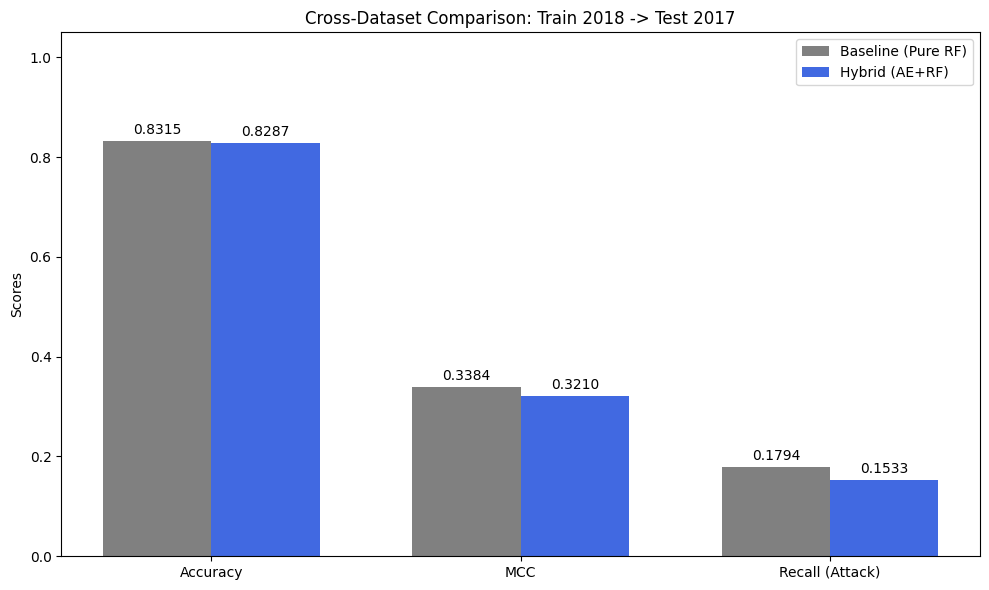

In [13]:
# ==============================================================================
# BATTLE: HYBRID MODEL (AE+RF) vs. PURE RF (BASELINE)
# ==============================================================================

print("\n🥊 BẮT ĐẦU SO SÁNH: PROPOSED METHOD vs. BASELINE 🥊")

# --- 1. Train Baseline (Pure RF với mRMR Features) ---
print("👉 Training Baseline RF (Only mRMR 20 features)...")
# X_train_mrmr ở đây là dữ liệu của 2018 (đã tạo ở Cell 5)

rf_baseline = rf_classifier.train_rf(
    X_train_mrmr_direct, 
    y_train, 
    save_path=exp_paths['models'] / "rf_baseline_2018.joblib"  # [THAY ĐỔI]: Tên file baseline 2018
) 

# --- 2. Evaluate Baseline ---
print("Evaluating Baseline on Test set (2017)...")
# X_test_mrmr ở đây là dữ liệu 2017
baseline_metrics = evaluation.evaluate_model(
    rf_baseline, 
    X_test_mrmr_direct, 
    y_test, 
    save_dir=None,
    dataset_name="Baseline (Pure RF)"
)

# --- 3. So sánh trực tiếp ---
hybrid_acc = metrics['accuracy'] 
baseline_acc = baseline_metrics['accuracy']

hybrid_mcc = metrics['mcc']
baseline_mcc = baseline_metrics['mcc']

# Lấy thêm Recall Attack
hybrid_recall = metrics['report']['Attack']['recall']
baseline_recall = baseline_metrics['report']['Attack']['recall']

print("\n📊 === BẢNG KẾT QUẢ ĐỐI ĐẦU (Train 18 -> Test 17) ===")
print(f"{'Metric':<20} | {'Baseline (Pure RF)':<20} | {'Hybrid (Proposed)':<20} | {'Improvement':<15}")
print("-" * 85)
print(f"{'Accuracy':<20} | {baseline_acc:.4f}{'':<14} | {hybrid_acc:.4f}{'':<14} | {hybrid_acc - baseline_acc:+.4f}")
print(f"{'MCC':<20} | {baseline_mcc:.4f}{'':<14} | {hybrid_mcc:.4f}{'':<14} | {hybrid_mcc - baseline_mcc:+.4f}")
print(f"{'Recall (Attack)':<20} | {baseline_recall:.4f}{'':<14} | {hybrid_recall:.4f}{'':<14} | {hybrid_recall - baseline_recall:+.4f}")

# --- 4. Vẽ biểu đồ ---
import matplotlib.pyplot as plt
import numpy as np

metrics_names = ['Accuracy', 'MCC', 'Recall (Attack)']
baseline_scores = [baseline_acc, baseline_mcc, baseline_recall]
hybrid_scores = [hybrid_acc, hybrid_mcc, hybrid_recall]

x = np.arange(len(metrics_names))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, baseline_scores, width, label='Baseline (Pure RF)', color='gray')
rects2 = ax.bar(x + width/2, hybrid_scores, width, label='Hybrid (AE+RF)', color='royalblue')

ax.set_ylabel('Scores')
ax.set_title('Cross-Dataset Comparison: Train 2018 -> Test 2017')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.legend()
ax.set_ylim([0, 1.05])

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.savefig(exp_paths['figures'] / "cross_dataset_reverse_comparison.png")
plt.show()